In [1]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, OneHotEncoder

from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.svm import SVR

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


## Import Dataset

In [16]:
df = pd.read_csv('C:/Users/Gerardo/Documents/Projects/ds4a/datasets/current_final_datset.csv')

cols_to_scale = ['Community_Spending','Unexpected_Housing_Spending','Govt_Direct_Expenditure','MedianIncome','Number_Interest_Groups','Property_Rights']
cols_to_onehot = ['No_Discrimination_Laws','Private_Fair_Housing',
                  'Public_Fair_Housing','Urban_Fair_Housing',
                  'Banned_Discrimination_Public_Housing',
                  'Banned_Discrimination_Private_Housing',
                  'Legislation_Public_Housing','Rent_Control',
                  'State_Aid_Allowed','Federal_Aid_Allowed',
                  'Prohibit_Rent_Control','Metro']
possible_labels = ['FMR0','Rent50','MedianIncome','FMRRentPercentInc','Rent50PercInc',
                   'Income_Adjusted_FMR0','Income_Adjusted_Rent50','Income_Adjusted_HousingPrices',
                   'Affordability_Price_Point','Housing_Prices_Quarter']

label_col = ['Income_Adjusted_FMR0']

cols_to_think_about = ['State','Year','County','Is_FMR0_Affordable','Is_Rent_Affordable']

y_df = df[possible_labels]
X_df = df[cols_to_scale + cols_to_onehot]

print('number of continuous features: ' + str(len(cols_to_scale)))
print('number of categorical features: ' + str(len(cols_to_onehot)))



number of continuous features: 6
number of categorical features: 12


In [17]:
from sklearn.base import BaseEstimator, TransformerMixin
class ExtractColumns(BaseEstimator,TransformerMixin):
    def __init__(self,attribute_names):
        self.attribute_names = attribute_names
    def fit(self,X,y = None):
        return self
    
    def transform(self,X):
        return X[self.attribute_names].values

In [47]:
def my_train_test_split(X,y,test_size = .2):
    tot_size = len(X)
    test_size = int(tot_size * test_size)
    

    test_indx = random.sample(range(tot_size),test_size)
    train_indx = np.setdiff1d(range(tot_size),test_indx)
   
    try:
        X_train = X.iloc[train_indx,:]
        X_test = X.iloc[test_indx,:]
   
        y_train = y.iloc[train_indx,:]
        y_test = y.iloc[test_indx,:]
    except:
        X_train = X[train_indx,:]
        X_test = X[test_indx,:]
   
        y_train = y[train_indx,:]
        y_test = y[test_indx,:]
        
    
    return X_train,X_test,y_train,y_test

In [20]:
label_pipeline = Pipeline([
    ('get_cols',ExtractColumns(label_col)),
    ('minmaxer',MinMaxScaler())
])

num_pipeline = Pipeline([
    ('get_cols',ExtractColumns(cols_to_scale)),
    ('scaler',StandardScaler())
])
cat_pipeline = Pipeline([
    ('get_cols',ExtractColumns(cols_to_onehot)),
    ('onehot',OneHotEncoder())
])

my_pipeline = ColumnTransformer([
    ('numerical',num_pipeline,cols_to_scale),
    ('categorical',cat_pipeline,cols_to_onehot),
    ('poly',PolynomialFeatures(degree=2),cols_to_onehot + cols_to_scale)
])



In [24]:
X_train, X_test, y_train, y_test = my_train_test_split(X_df,y_df,test_size = .3) #70% training
X_val, X_test, y_val,y_test = my_train_test_split(X_test,y_test,test_size = .5) #15% validation

y_train = label_pipeline.fit_transform(y_train) #only fit the scaling to the test dataset
X_train = my_pipeline.fit_transform(X_train)

y_test = label_pipeline.transform(y_test) #transform but don't fit the scaling to the test/validation dataset
X_test = my_pipeline.transform(X_test)
y_val = label_pipeline.transform(y_val)
X_val = my_pipeline.transform(X_val)



In [37]:
def train_model(model,X_train,X_test,y_train,y_test):
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    
    score = np.sqrt(mean_squared_error(y_test,pred))
    r2 = r2_score(y_test,pred)
    plt.scatter(pred,y_test)
    plt.plot([0,pred.max()],[0,pred.max()],color ='red');
    plt.title('score: ' + str(round(score,2)) + ' r2: ' + str(round(r2,2)))
    
    return score,model

(0.06548694960760187, LinearRegression())

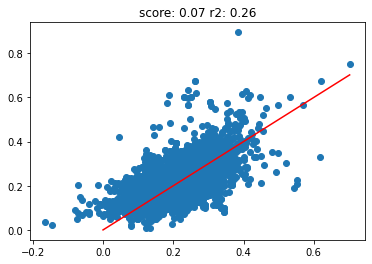

In [46]:
train_model(LinearRegression(),X_train,X_test,y_train,y_test)

C:\Users\Gerardo\.virtualenvs\ds4a\lib\site-packages\sklearn\ensemble\_voting.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[Voting] ............ (1 of 3) Processing random_forest, total= 5.1min
[Voting] ...................... (2 of 3) Processing sgd, total=   0.6s
[Voting] .................... (3 of 3) Processing ridge, total=   0.1s


C:\Users\Gerardo\.virtualenvs\ds4a\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.89105e-24): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


(1.0471129351463035e+23,
 VotingRegressor(estimators=[('random_forest',
                              RandomForestRegressor(max_depth=8,
                                                    min_samples_split=16,
                                                    n_estimators=500)),
                             ('sgd',
                              SGDRegressor(eta0=1e-07, l1_ratio=0.5,
                                           learning_rate='constant',
                                           penalty='elasticnet',
                                           random_state=42)),
                             ('ridge', Ridge(alpha=0.9))],
                 verbose=True))

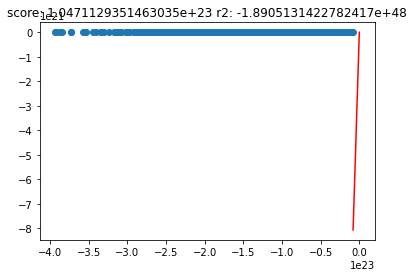

In [45]:
for_reg = RandomForestRegressor(n_estimators = 500, max_depth = 8,min_samples_split = 16)
svr_reg = SVR(kernel='poly',degree=2,C=1E3)
sgd_reg = SGDRegressor(penalty= 'elasticnet',l1_ratio = .5,random_state= 42,learning_rate = 'constant',eta0 = 1E-7)
ridge_reg = Ridge(alpha = .9)

ensemble = VotingRegressor(estimators = [
    ('random_forest',for_reg),
    ('sgd',sgd_reg),
    ('ridge',ridge_reg)
], verbose = True)

train_model(ensemble,X_train,X_test,y_train,y_test)

In [44]:
from statsmodels.formula.api import ols

formula = 'Rent50 ~ Year + State + County + MedianIncome + Metro + No_Discrimination_Laws + Private_Fair_Housing + Public_Fair_Housing + Urban_Fair_Housing + Banned_Discrimination_Public_Housing + Legislation_Public_Housing + Rent_Control + State_Aid_Allowed + Prohibit_Rent_Control'
model = ols(formula,data = df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rent50   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     102.2
Date:                Mon, 14 Feb 2022   Prob (F-statistic):               0.00
Time:                        18:47:12   Log-Likelihood:            -4.0113e+05
No. Observations:               46804   AIC:                         8.061e+05
Df Residuals:                   44874   BIC:                         8.230e+05
Df Model:                        1929                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
Intercept                                             -9.555e+04   3962.535    -24.114      0.000   -1.03e+05   -8.78e+04
State[T.AL]                                               8.3801     66.964      0.125      0.900    -122.871     139.631
State[T.AR]                                             -71.1728     65.225     -1.091      0.275    -199.016      56.670
State[T.AZ]                                            1378.9810    310.298      4.444      0.000     770.793    1987.169
State[T.CA]                                            -587.6566    150.264     -3.911      0.000    -882.177    -293.136
State[T.CO]                                            2303.9607    120.087     19.186      0.000    2068.589    2539.332
State[T.CT]                                            1553.9438    131.729     11.797      0.000    1295.752    1812.135
State[T.DE]                                           -1286.1722    304.954     -4.218      0.000   -1883.886    -688.458
State[T.FL]                                            2139.6395     77.753     27.519      0.000    1987.243    2292.036
State[T.GA]                                             917.5999     51.317     17.881      0.000     817.018    1018.182
State[T.HI]                                           -5297.0719    487.868    -10.858      0.000   -6253.302   -4340.842
State[T.IA]                                           -9421.4609    299.119    -31.497      0.000      -1e+04   -8835.183
State[T.ID]                                             311.9717    109.846      2.840      0.005      96.672     527.272
State[T.IL]                                            3140.6504    172.983     18.156      0.000    2801.600    3479.700
State[T.IN]                                             256.6574     71.912      3.569      0.000     115.708     397.607
State[T.KS]                                           -1.798e+04    674.887    -26.644      0.000   -1.93e+04   -1.67e+04
State[T.KY]                                            -229.4480     53.571     -4.283      0.000    -334.447    -124.449
State[T.LA]                                            2184.7152    413.083      5.289      0.000    1375.065    2994.365
State[T.MA]                                            4983.6098    117.055     42.575      0.000    4754.180    5213.040
State[T.MD]                                             520.6472    116.932      4.453      0.000     291.458     749.837
State[T.ME]                                           -1661.0640    105.634    -15.725      0.000   -1868.109   -1454.019
State[T.MI]                                           -2112.3221    105.156    -20.087      0.000   -2318.430   -1906.214
State[T.MN]                      